# Data Loading

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import glob
import numpy as np 


# Specify the path to your dataset
path = "data"
data = []
labels = []

# Function to extract audio samples and labels
def extract_audio_sample(data,labels,path):
    # List all the folders in the dataset path
    speakers = os.listdir(path)

    for i, speaker in enumerate(speakers):
        # List all audio files for the speaker
        files = glob.glob(os.path.join(path, speaker, "*.wav"))

       # Append data and labels to train and test
        data.extend(files)
        labels.extend([speaker] * len(files))

    return data, labels

data,labels = extract_audio_sample(data,labels,path)

#Dictionary labels to integers
label2int = {k: v for v, k in enumerate(set(labels))}
#Reverse Dictionary Integers to Labels
int2label = {v: k for k, v in label2int.items()}
#Convert labels to integers
labels = [label2int[i] for i in labels]

# Embedding

In [10]:
#Import the pyannote model acheiving state-oft-the-art results in speaker embedding for speaker verification due to its X-Vector and SincNet fusion architecture
from pyannote.audio import Model
pipeline = Model.from_pretrained("pyannote/embedding",use_auth_token=os.getenv('HF_TOKEN'))

Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\noahg\.cache\torch\pyannote\models--pyannote--embedding\snapshots\4db4899737a38b2d618bbd74350915aa10293cb2\pytorch_model.bin`
Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\noahg\.cache\torch\pyannote\models--pyannote--embedding\snapshots\4db4899737a38b2d618bbd74350915aa10293cb2\pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.1.2+cpu. Bad things might happen unless you revert torch to 1.x.
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.1.2+cpu. Bad things might happen unless you revert torch to 1.x.


In [11]:
from pyannote.audio import Inference

inference = Inference(pipeline, window="whole")

dataset = []
#Extract embeddings for each audio file
for i in range(len(data)):
    embedding = inference(data[i])
    dataset.append(embedding)

# Class visualisations

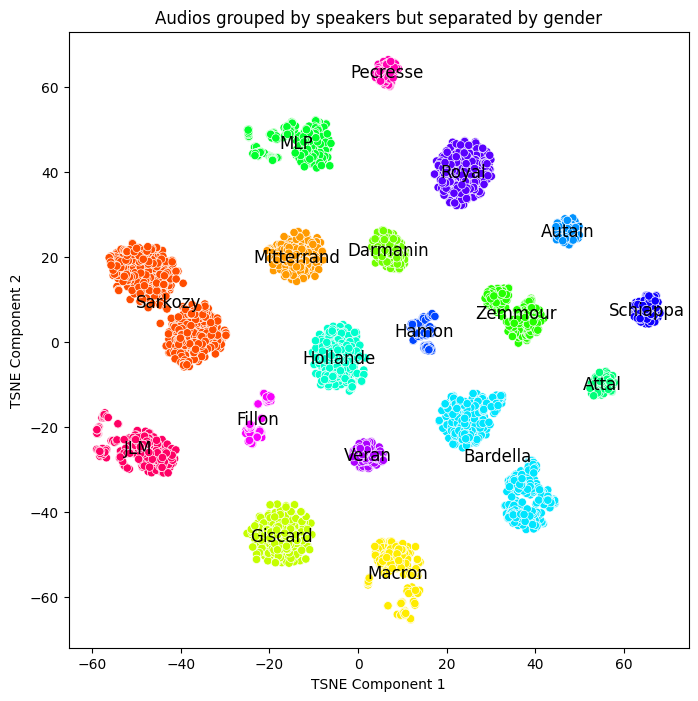

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Apply t-SNE to the dataset and visualize the embeddings with the labels as the color
datax = [np.reshape(x, (1, -1)) if x.ndim == 1 else x for x in dataset]
X = np.concatenate(datax, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

# Create a DataFrame
df = pd.DataFrame(X_2d, columns=['x', 'y'])
df['label'] = labels
df['speaker'] = df['label'].map(int2label)

# Adds a column to the DataFrame to specify the gender of the speaker
df['gender'] = df['label'].apply(lambda x: 'female' if x in [1, 10, 12, 14, 16] else 'male')

# Define the features (X) and target (y)
X_features = df[['x', 'y']]
y_target = df['gender'].map({'female': 1, 'male': 0})  # Map gender to numeric labels

# Plot the decision boundary
plt.figure(figsize=(8,8))


# Plot the original scatter plot with the original colors
sns.scatterplot(x='x', y='y', hue='label', data=df, palette=sns.color_palette("hsv", 18))

# Add label numbers at the center of each packet (cluster of points)
for label in df['label'].unique():
    group = df[df['label'] == label]
    centroid = group[['x', 'y']].mean()  # Calculate the centroid
    plt.text(centroid['x'], centroid['y'], int2label[label], color='black', fontsize=12, ha='center', va='center')

# Customize the plot
plt.title('Audios grouped by speakers but separated by gender')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend([],[], frameon=False)
plt.show()

# Speaker similarity

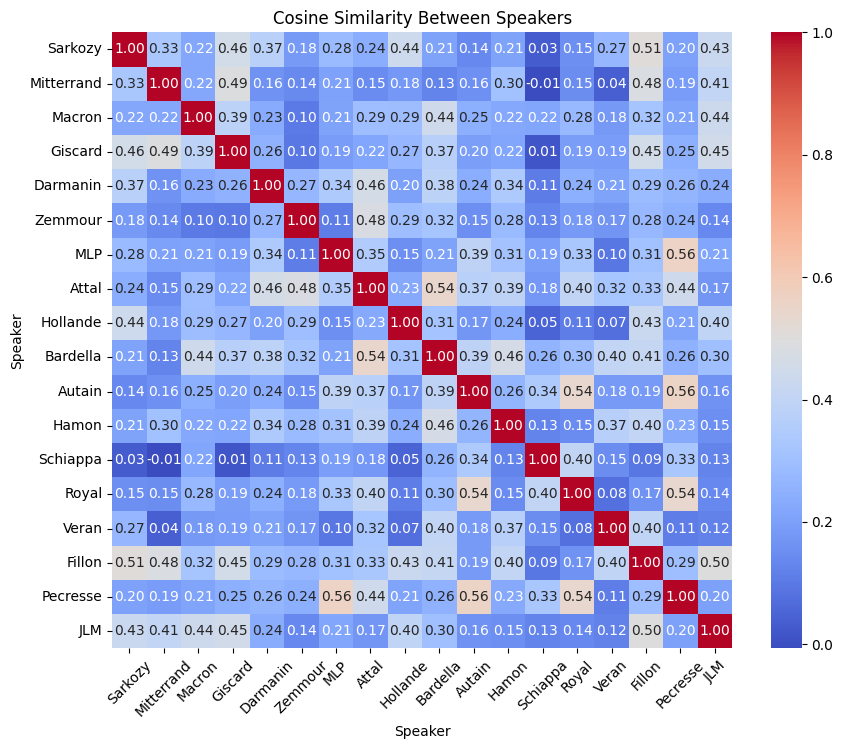

In [13]:
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame for embeddings and their corresponding speakers
embedding_df = pd.DataFrame(X)  # Use embeddings (X from earlier)
embedding_df['speaker'] = labels  # Attach speaker labels

# Compute the average embedding for each speaker
speaker_averages = embedding_df.groupby('speaker').mean()

# Extract speaker names
speakers = speaker_averages.index.map(int2label)

# Compute cosine similarities between speaker average embeddings
similarity_matrix = cosine_similarity(speaker_averages)

# Create a DataFrame for the similarity matrix with speaker labels
similarity_df = pd.DataFrame(similarity_matrix, index=speakers, columns=speakers)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Cosine Similarity Between Speakers")
plt.xlabel("Speaker")
plt.ylabel("Speaker")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


# Classification

In [14]:
#Create a tensorflow cnn model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Assuming that `data` is your dataset and `labels` are your target labels
train_data, test_data, train_labels, test_labels = train_test_split(dataset, labels, test_size=0.25, random_state=42)

#clear session
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(512,1)))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(18, activation='softmax'))


best_model = tf.keras.callbacks.ModelCheckpoint(
    'best_model_1.h5',
    monitor='val_loss', # Monitor other things like val_accuracy or accuracy 
    save_best_only='True', # Make sure to save only the best model
    verbose=1
)


model.compile(optimizer="adam",
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])

train_features = np.array(train_data)
train_labels = np.array(train_labels)
test_features = np.array(test_data)
test_labels = np.array(test_labels)

model.fit(train_features, train_labels, validation_data=(test_features,test_labels),epochs=10, batch_size=32,callbacks=[best_model])


Epoch 1/10
107/108 [============================>.] - ETA: 0s - loss: 3.2299 - sparse_categorical_accuracy: 0.6016
Epoch 1: val_loss improved from inf to 0.02140, saving model to best_model_1.h5
108/108 [==============================] - 4s 23ms/step - loss: 3.2168 - sparse_categorical_accuracy: 0.6033 - val_loss: 0.0214 - val_sparse_categorical_accuracy: 0.9983
Epoch 2/10
105/108 [============================>.] - ETA: 0s - loss: 0.0863 - sparse_categorical_accuracy: 0.9723
Epoch 2: val_loss improved from 0.02140 to 0.01254, saving model to best_model_1.h5
108/108 [==============================] - 2s 19ms/step - loss: 0.0852 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.0125 - val_sparse_categorical_accuracy: 0.9991
Epoch 3/10
105/108 [============================>.] - ETA: 0s - loss: 0.0316 - sparse_categorical_accuracy: 0.9920
Epoch 3: val_loss did not improve from 0.01254
108/108 [==============================] - 2s 21ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.

# Plots

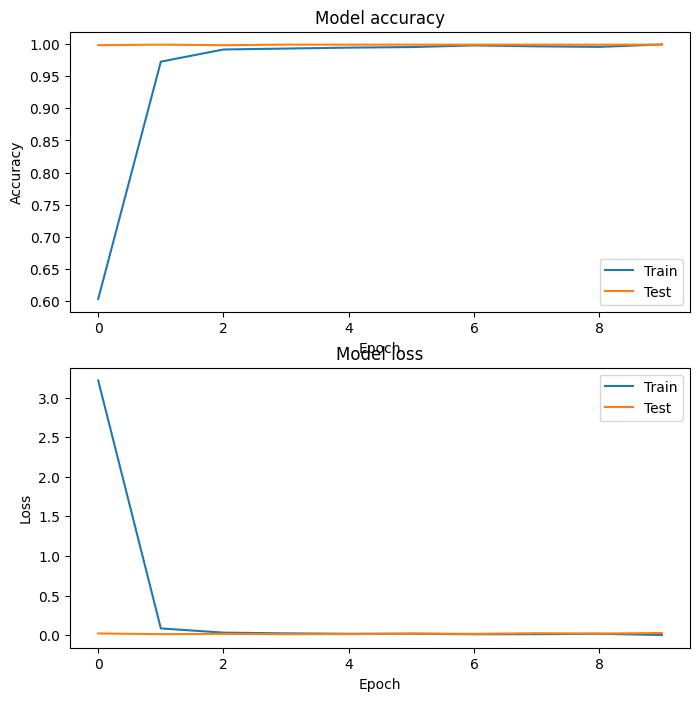

In [15]:
#plot the loss and accuracy curves for training and validation
import matplotlib.pyplot as plt
history = model.history
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

In [16]:
# Show me the validation accuracy, precision, recall, and F1 score

from sklearn.metrics import classification_report
y_pred = model.predict(test_features)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred))

36/36 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00        70
           3       1.00      1.00      1.00        86
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        74
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        85
           9       1.00      0.99      1.00       147
          10       1.00      1.00      1.00        34
          11       1.00      1.00      1.00        34
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        83
          14       0.98      1.00      0.99        44
          15       1.00      1.00      1.00        34
          16       1.00     

# Confusion Matrix

36/36 [==============================] - 0s 6ms/step


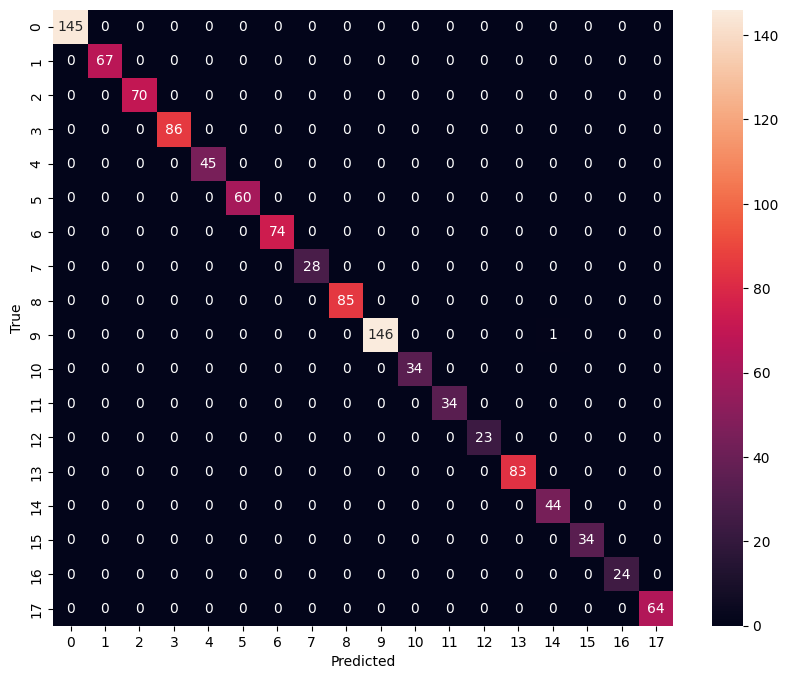

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model = tf.keras.models.load_model(r'best_model_1.h5')
for data in test_data:
    data = data.reshape(1,512,1)
y_pred = model.predict(np.stack(test_data))
y_pred = np.argmax(y_pred, axis=1)

confusion_mtx = confusion_matrix(test_labels, y_pred) 
labels = np.unique(np.concatenate([test_labels, y_pred]))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### Notebook réalisé par Noah Goulin